# 區域性切空間排列(Local Tangent Space Alignment)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm
from random import choices

# MNIST Dataset

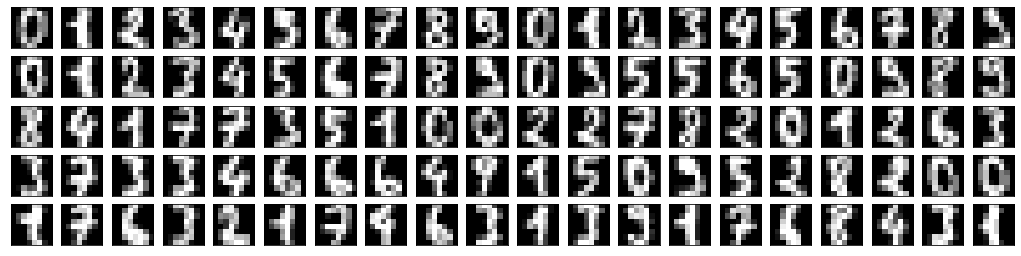

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Ball Tree

In [3]:
def BuildSubtree(root,points,index,leaf_size,depth):
    if(depth==0):
        return
    centroid=np.mean(points[index,:],axis=0)
    root.centroid=centroid
    root.radius=np.max(np.sum((points[index,:]-centroid)**2,axis=1))**0.5
    farthest_point_1=np.argmax(np.sum((points[index,:]-centroid)**2,axis=1))
    real_index_1=index[farthest_point_1]
    distance_array_1=np.sum((points[index,:]-points[real_index_1,:])**2,axis=1)
    farthest_point_2=np.argmax(np.sum((points[index,:]-points[real_index_1,:])**2,axis=1))
    real_index_2=index[farthest_point_2]
    distance_array_2=np.sum((points[index,:]-points[real_index_2,:])**2,axis=1)
    BOOL=(distance_array_1<=distance_array_2)
    child1_index,child2_index=index[BOOL],index[~BOOL]
    root.index1,root.index2=real_index_1,real_index_2
    if(len(child1_index)<=leaf_size and len(child2_index)<=leaf_size):
        if(depth==1):
            print("tree is not complete")
        root.child1="end"
        root.child2="end"
    elif(len(child1_index)<=leaf_size):
        root.child1="end"
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    elif(len(child2_index)<=leaf_size):
        root.child2="end"
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
    else:
        root.child1=Tree()
        BuildSubtree(root.child1,points,child1_index,leaf_size,depth-1)
        root.child2=Tree()
        BuildSubtree(root.child2,points,child2_index,leaf_size,depth-1)
    return

# k-Nearest Neighbor Search

In [4]:
def check(X,p,k,Q,index):
    if(np.sum((p-X[index,:])**2)<np.sum((p-X[Q[0],:])**2)):
        Q.append(index)
        Q=np.array(Q)
        Q=list(Q[np.argsort(-1*np.sum((p-X[Q,:])**2,axis=1))])
        if(len(Q)>k):    
            del Q[0]
    return Q

def kNN_search(X,p,k,Q,root):
    if(np.sqrt(np.sum((p-root.centroid)**2))-root.radius>=np.sqrt(np.sum((p-X[Q[0],:])**2))):
        return Q
    elif(root.child1=="end" and root.child2=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=check(X,p,k,Q,root.index2)
    elif(root.child1=="end"):
        Q=check(X,p,k,Q,root.index1)
        Q=kNN_search(X,p,k,Q,root.child2)
    elif(root.child2=="end"):
        Q=check(X,p,k,Q,root.index2)
        Q=kNN_search(X,p,k,Q,root.child1)
    else:
        Q=kNN_search(X,p,k,Q,root.child1)
        Q=kNN_search(X,p,k,Q,root.child2)
    return Q    

# Building Tree and Nearest Neighbor

In [5]:
class Tree:
    def __init__(self):
        self.child1=None
        self.child2=None
        self.radius=None
        self.centroid=None
        self.index1=None
        self.index2=None
root=Tree()
N,M=X.shape
Index=np.array(range(0,N))
BuildSubtree(root,X,Index,1,30)
k=30
neighbors =np.zeros((N,k))
for i in tqdm(range(0,N)):
    Q=[]
    while(len(Q)!=k+1):
        Q=list(np.random.randint(N,size=1))
        Q=kNN_search(X,X[i,:],k+1,Q,root)
    del Q[k]
    neighbors[i]=Q

# LTSA

In [6]:
B=np.zeros((N,N))
n_components=2
n_neighbors=k
neighbors=neighbors.astype(int)
for i in tqdm(range(N)):
    tensor=X[neighbors[i],:]-np.mean(X[neighbors[i],:],axis=0)
    V=np.linalg.svd(tensor,full_matrices=True)[0]
    Gi = np.zeros((n_neighbors, n_components + 1))
    Gi[:, 1:] = V[:, :n_components]
    Gi[:, 0] = 1.0 / np.sqrt(n_neighbors)
    GiGiT = np.dot(Gi, Gi.T)
    nbrs_x, nbrs_y = np.meshgrid(neighbors[i], neighbors[i])
    B[nbrs_x, nbrs_y] -= GiGiT
    B[neighbors[i], neighbors[i]] += 1
U,V=np.linalg.eig(B)
idx=np.argsort(U.real)
X_sub=(V[:,idx[1:3]]).real

# Plot

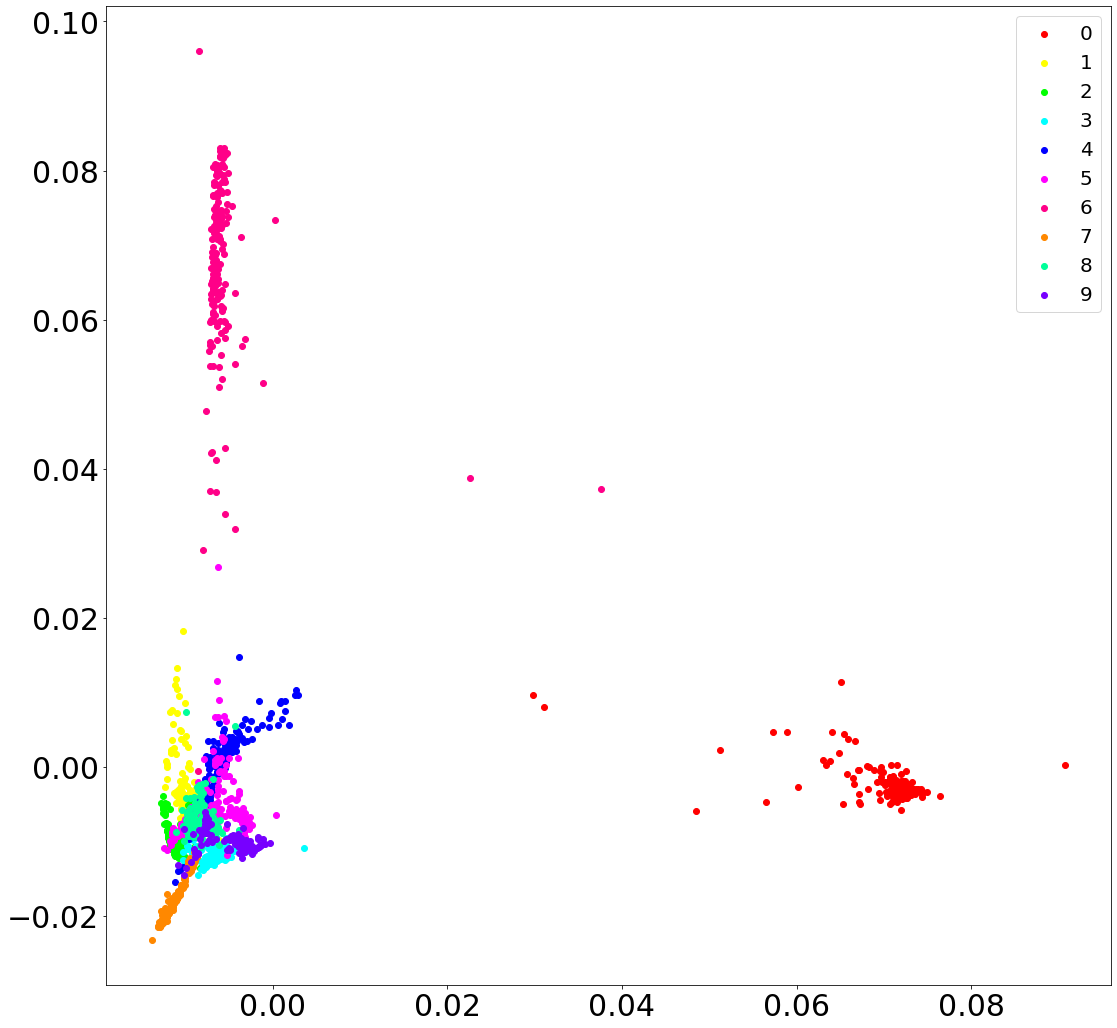

In [7]:
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,18)
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_sub[BOOL,0],X_sub[BOOL,1],c=color[i],label=i)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=20)
plt.show()